# KAN-ODE

In [29]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch.distributions as dists
import pandas as pd
from base_kan.ekan import EKAN 

In [ ]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = [] 

    def forward(self, t, y):
        S, I, R, A = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        dA_dt = abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])

In [ ]:
gamma = 0.05
beta = 0.12 
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

In [ ]:
intial = 0.  #
last= 100.    
step = 100   #
y0 = torch.tensor([0.99, 0.01, 0.0, 0.0], requires_grad=True)  
t = torch.linspace(intial, last, step)  

In [34]:
def get_data():
    gamma = 0.05
    beta = 0.12
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.5
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * torch.exp(-a*I) * I
        dI_dt = beta * S * torch.exp(-a*I) * I  - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * torch.exp(-a*I) * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

In [35]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 3] - true_y[:, 3]) ** 2)

In [36]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 3] - true_y[:, 3])
    correct = (diff < threshold).float().mean()
    return correct.item()

In [ ]:
def forword_CF(x):
    
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    
    result = x.clone().detach()
    
   
    result[1:] = x[1:] - x[:-1]
    
    return result

In [38]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(2000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

In [39]:
t, True_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.7768548727035522, Accuracy: 1.00%
Iter 100, Loss: 0.025488298386335373, Accuracy: 3.00%
Iter 200, Loss: 0.005177352577447891, Accuracy: 8.00%
Iter 300, Loss: 0.00030618475284427404, Accuracy: 32.00%
Iter 400, Loss: 0.00017327356908936054, Accuracy: 38.00%
Iter 500, Loss: 0.00014887156430631876, Accuracy: 42.00%
Iter 600, Loss: 0.00012477221025619656, Accuracy: 46.00%
Iter 700, Loss: 0.00010232897329842672, Accuracy: 52.00%
Iter 800, Loss: 8.211347449105233e-05, Accuracy: 58.00%
Iter 900, Loss: 6.450123328249902e-05, Accuracy: 70.00%
Iter 1000, Loss: 4.957127384841442e-05, Accuracy: 96.00%
Iter 1100, Loss: 3.729158561327495e-05, Accuracy: 98.00%
Iter 1200, Loss: 2.7443482395028695e-05, Accuracy: 100.00%
Iter 1300, Loss: 1.978641375899315e-05, Accuracy: 100.00%
Iter 1400, Loss: 1.398619406245416e-05, Accuracy: 100.00%
Iter 1500, Loss: 9.7266010925523e-06, Accuracy: 100.00%
Iter 1600, Loss: 6.6873535615741275e-06, Accuracy: 100.00%
Iter 1700, Loss: 4.582908786687767e-06, A

In [40]:
True_y[:,3] = forword_CF(True_y[:,3])
pred_y[:,3] = forword_CF(pred_y[:,3])

/tmp/ipykernel_899373/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [41]:
tdata = {
    'Time': t.numpy(),
    'True_S': True_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': True_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': True_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
    'True_A': True_y.numpy()[:, 3],
    'Predicted_A': pred_y.detach().numpy()[:, 3],

}

dft = pd.DataFrame(tdata)

In [42]:
dft.to_excel('ZS-t.xlsx', index=False)

In [43]:
def get_data():
    gamma = 0.05
    beta = 0.12
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.5
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * torch.exp(-a*I) * I
        dI_dt = beta * S * torch.exp(-a*I) * I  - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * torch.exp(-a*I) * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, y = get_data()

In [ ]:
#
y = y * 10000
#
poisson_dist = dists.Poisson(y)
#
poisson_noise = poisson_dist.sample()
true_y = poisson_noise/10000
y = y/10000

In [45]:
t, Z_true_y, Z_pred_y, Z_neural_outputs = train()

Iter 0, Loss: 4.0028928196989e-05, Accuracy: 89.00%
Iter 100, Loss: 0.011509128846228123, Accuracy: 4.00%


Iter 200, Loss: 0.004862447734922171, Accuracy: 8.00%
Iter 300, Loss: 0.0038056413177400827, Accuracy: 7.00%
Iter 400, Loss: 0.003325625555589795, Accuracy: 10.00%
Iter 500, Loss: 0.0027989796362817287, Accuracy: 11.00%
Iter 600, Loss: 0.002299495507031679, Accuracy: 11.00%
Iter 700, Loss: 0.001845836522988975, Accuracy: 14.00%
Iter 800, Loss: 0.0014470196329057217, Accuracy: 15.00%
Iter 900, Loss: 0.0011074533686041832, Accuracy: 15.00%
Iter 1000, Loss: 0.000828046933747828, Accuracy: 18.00%
Iter 1100, Loss: 0.0006065086927264929, Accuracy: 19.00%
Iter 1200, Loss: 0.00043778365943580866, Accuracy: 24.00%
Iter 1300, Loss: 0.00031464290805161, Accuracy: 31.00%
Iter 1400, Loss: 0.00022866364452056587, Accuracy: 35.00%
Iter 1500, Loss: 0.00017126942111644894, Accuracy: 43.00%
Iter 1600, Loss: 0.00013458986359182745, Accuracy: 54.00%
Iter 1700, Loss: 0.00011202377936569974, Accuracy: 57.00%
Iter 1800, Loss: 9.854057134361938e-05, Accuracy: 60.00%
Iter 1900, Loss: 9.05528650037013e-05, Accu

In [ ]:

y = True_y[:,3] * 10000

poisson_dist = dists.Poisson(y)

poisson_noise = poisson_dist.sample()
Z_true_y[:,3] = poisson_noise/10000

In [47]:
Z_pred_y[:,3] = forword_CF(Z_pred_y[:,3])

/tmp/ipykernel_899373/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [48]:
tdata = {
    'Time': t.numpy(),
    'True_S': Z_true_y.numpy()[:, 0],
    'Predicted_S': Z_pred_y.detach().numpy()[:, 0],
    'True_I': Z_true_y.numpy()[:, 1],
    'Predicted_I': Z_pred_y.detach().numpy()[:, 1],
    'True_R': Z_true_y.numpy()[:, 2],
    'Predicted_R': Z_pred_y.detach().numpy()[:, 2],
    'True_A': Z_true_y.numpy()[:, 3],
    'Predicted_A': Z_pred_y.detach().numpy()[:, 3],
}

dft = pd.DataFrame(tdata)



In [49]:
dft.to_excel('ZS-zt.xlsx', index=False)

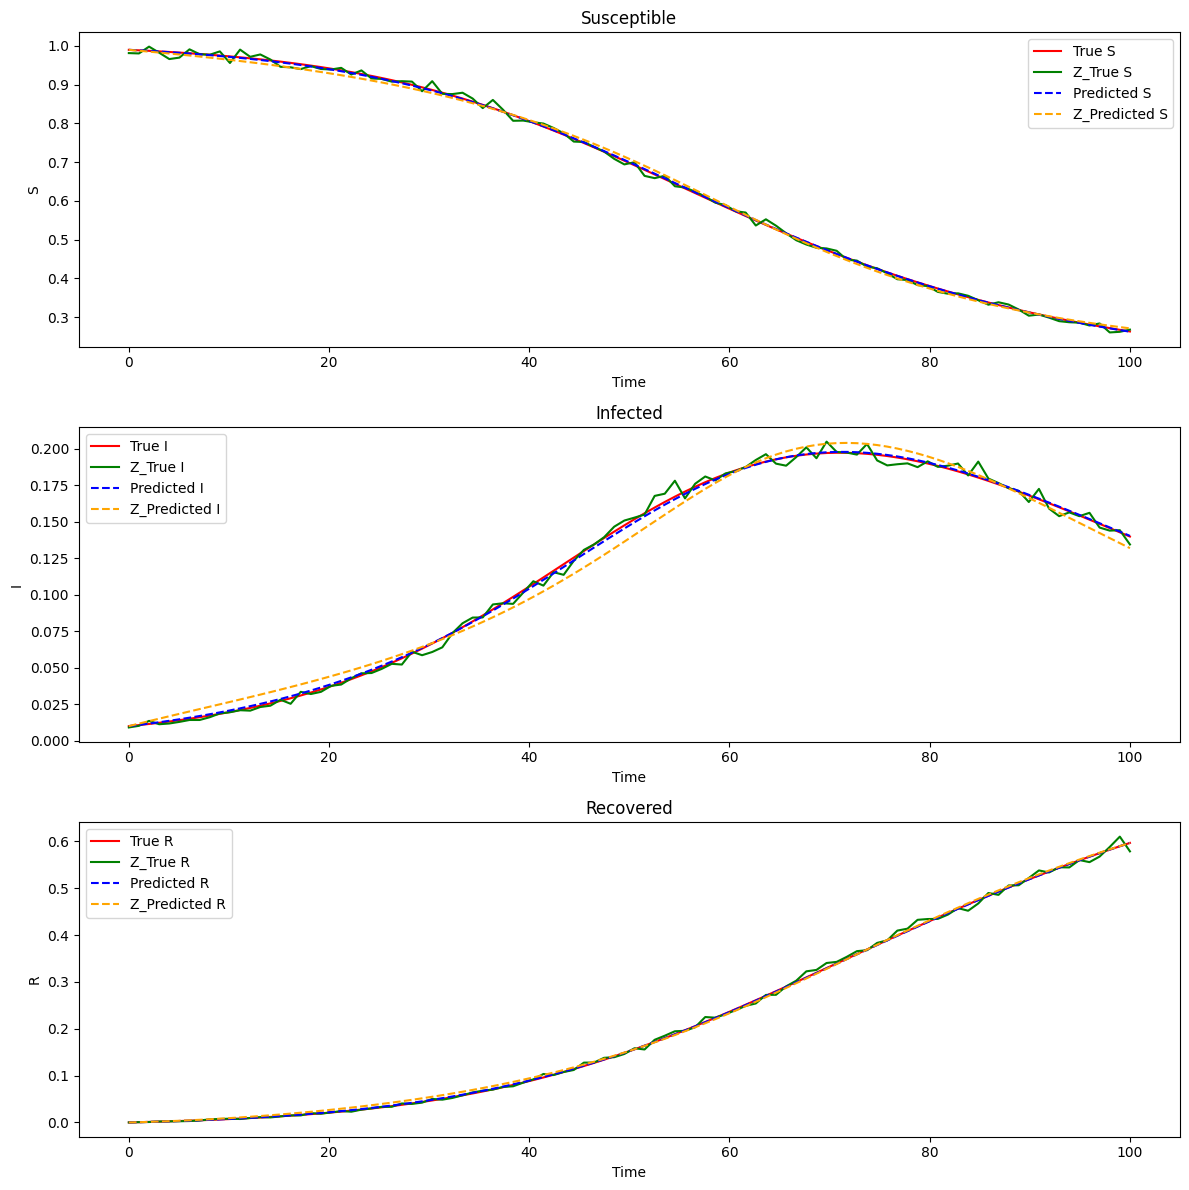

In [50]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), True_y.numpy()[:, 0], '-', label='True S', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 0], '-', label='Z_True S', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], '--', label='Predicted S', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 0], '--', label='Z_Predicted S', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), True_y.numpy()[:, 1], '-', label='True I', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 1], '-', label='Z_True I', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], '--', label='Predicted I', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 1], '--', label='Z_Predicted I', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), True_y.numpy()[:, 2], '-', label='True R', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 2], '-', label='Z_True R', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], '--', label='Predicted R', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 2], '--', label='Z_Predicted R', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')


plt.tight_layout()
plt.show()


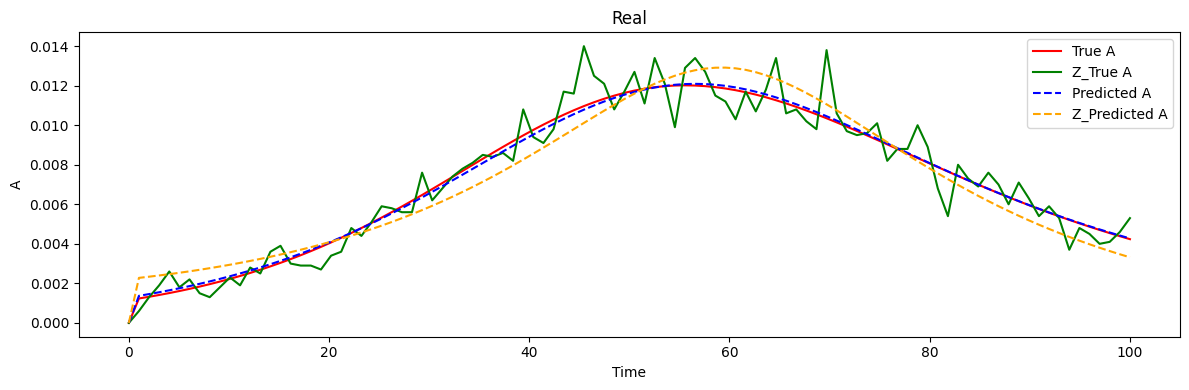

In [51]:
plt.figure(figsize=(12, 4))

plt.plot(t.numpy(), True_y.numpy()[:, 3], '-', label='True A', color='red')
plt.plot(t.numpy(), Z_true_y.detach().numpy()[:, 3], '-', label='Z_True A', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 3], '--', label='Predicted A', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 3], '--', label='Z_Predicted A', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')


plt.tight_layout()
plt.show()